<a href="https://colab.research.google.com/github/edusangalli/tcc_puc_minas/blob/main/tcc_puc_minas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Previsão de Vendas**

# **Sumário**

# **1. Introdução**

Trabalho de conclusão de curso PUC-Minas. Previsão de vendas utilizando base do kaggle. Utlizaremos os dados dos anos 2013 e 2014 para prever a venda do ano de 2015.

# **2. Coleta de Dados**

## 2.1 Instalação de Bibliotecas



In [1]:
!pip install googletrans==3.1.0a0

## 2.2 Importar Bibliotecas



In [2]:
# Basicas
import numpy as np 
import pandas as pd 
import time
from math import sqrt

# Gráficas
import matplotlib.pyplot as plt
import seaborn as sns
from fbprophet.plot import add_changepoints_to_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Séries Temporais
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

# Tradução
from googletrans import Translator

# Retira Advertencias
#%matplotlib inline
import warnings
warnings.filterwarnings("ignore")



/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



## 2.3 Funções

In [3]:
# Função de tradução do Russo Para Português
tradutor = Translator()
def traduzir(value):
    td = tradutor.translate(value, src="ru", dest="pt")
    return td.text

In [4]:
def test_stationarity(timeseries):
    
    #Teste Dickey-Fuller:
    print('Resultado do teste de Dickey-Fuller:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

## 2.4 Importar Dados

In [5]:
# Coleta de dados
data_url = 'https://github.com/edusangalli/tcc_puc_minas/blob/main/dados/'

lojas_df          = pd.read_csv(data_url + 'shops.csv?raw=true')                                                                 # Lojas
categorias_df     = pd.read_csv(data_url + 'item_categories.csv?raw=true')                                                       # Categorias
itens_df          = pd.read_csv(data_url + 'items.csv.zip?raw=true', compression='zip', header=0, sep=',', quotechar='"')        # Itens
vendas_df         = pd.read_csv(data_url + 'sales_train.csv.zip?raw=true', compression='zip', header=0, sep=',', quotechar='"')  # Vendas Treino


In [6]:
#Tamanho dos datasets
print('---------Lojas----------')
print(lojas_df.shape)
print('---------Itens----------')
print(itens_df.shape)
print('---------Categorias----------')
print(categorias_df.shape)
print('---------Vendas----------')
print(vendas_df.shape)
#print('---------Vendas Teste----------')
#print(vendas_teste_df.shape)

---------Lojas----------
(60, 2)
---------Itens----------
(22170, 3)
---------Categorias----------
(84, 2)
---------Vendas----------
(2935849, 6)


# **3. Processamento/Tratamento dos dados**

## 3.1 Análise do Dataset de Lojas

### 3.1.1 Informações

In [7]:
print('---------Lojas----------')
lojas_df.info()

---------Lojas----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   shop_name  60 non-null     object
 1   shop_id    60 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


Podemos verificar que o dataset não possuem dados nulos e que as colunas estão no tipos corretos, alfanuméricos e inteiro

In [8]:
# Observar os primeiros registros
lojas_df.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


### 3.1.2 Tradução



Podemos notar que nome da lojas não estão em Português.

In [9]:
# Confirmando o idioma do nome de lojas
str(tradutor.detect(lojas_df['shop_name'].loc[1]))

'Detected(lang=ru, confidence=1)'

Após a confirmação do idioma Russo podemos passar para tradução e adição de uma nova coluna no dataset com o idioma traduzido para o portugues.

In [10]:
# Comentado a tradução e carregado arquivo já traduzido por questão de tempo de processamento.
#lojas_df["shop_name_pt"] = lojas_df.shop_name.map(traduzir)
lojas_df          = pd.read_csv(data_url + 'shops_traduzidas_df.csv?raw=true')                                                      
print(lojas_df.head())

                        shop_name  ...                            shop_name_pt
0   !Якутск Орджоникидзе, 56 фран  ...     ! Yakutsk Ordzhonikidze, 56 francos
1   !Якутск ТЦ "Центральный" фран  ...             ! Yakutsk TC fran "Central"
2                Адыгея ТЦ "Мега"  ...          Centro comercial Adygea "Mega"
3  Балашиха ТРК "Октябрь-Киномир"  ...        Balashikha TRK "Outubro-Kinomir"
4        Волжский ТЦ "Волга Молл"  ...  Centro comercial Volzhsky "Volga Mall"

[5 rows x 3 columns]


### 3.1.3 Registros duplicados

In [11]:
lojas_df.loc[[0,57,1,58,10,11,39,40]]

,shop_name,shop_id,shop_name_pt
0,"!Якутск Орджоникидзе, 56 фран",0,"! Yakutsk Ordzhonikidze, 56 francos"
57,"Якутск Орджоникидзе, 56",57,"Yakutsk Ordzhonikidze, 56"
1,"!Якутск ТЦ ""Центральный"" фран",1,"! Yakutsk TC fran ""Central"""
58,"Якутск ТЦ ""Центральный""",58,"Yakutsk TC ""Central"""
10,Жуковский ул. Чкалова 39м?,10,Zhukovsky st. Chkalov 39m?
11,Жуковский ул. Чкалова 39м²,11,Zhukovsky st. Chkalov 39m²
39,"РостовНаДону ТРК ""Мегацентр Горизонт""",39,"Rostov em Don TRK ""Megacenter Horizon"""
40,"РостовНаДону ТРК ""Мегацентр Горизонт"" Островной",40,"Rostov em Don TRC ""Megacenter Horizon"" Ostrovnoy"


In [12]:
#lojas_df.loc[[0,1,10,39]].drop

## 3.2 Análise do Dataset de Categorias

### 3.2.1 Informações

In [13]:
print('---------Categorias----------')
categorias_df.info()

---------Categorias----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   item_category_name  84 non-null     object
 1   item_category_id    84 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


Podemos verificar que o dataset não possuem dados nulos e que as colunas estão no tipos corretos, alfanumérico e inteiro.

In [14]:
# Observar os primeiros registros
print(categorias_df.head())

        item_category_name  item_category_id
0  PC - Гарнитуры/Наушники                 0
1         Аксессуары - PS2                 1
2         Аксессуары - PS3                 2
3         Аксессуары - PS4                 3
4         Аксессуары - PSP                 4


In [15]:
categorias_df

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
...,...,...
79,Служебные,79
80,Служебные - Билеты,80
81,Чистые носители (шпиль),81
82,Чистые носители (штучные),82


### 3.2.2 Tradução

In [16]:
# Comentado a tradução e carregado arquivo já traduzido por questão de tempo de processamento.
#categorias_df["item_category_name_pt"] = categorias_df.item_category_name.map(traduzir)
categorias_df     = pd.read_csv(data_url + 'item_categories_trad.csv?raw=true')                                                       # Categorias
print(categorias_df.head())

        item_category_name  ...                   item_category_name_pt
0  PC - Гарнитуры/Наушники  ...  PC - Fones de ouvido / Fones de ouvido
1         Аксессуары - PS2  ...                        Acessórios - PS2
2         Аксессуары - PS3  ...                        Acessórios - PS3
3         Аксессуары - PS4  ...                        Acessórios - PS4
4         Аксессуары - PSP  ...                        Acessórios - PSP

[5 rows x 3 columns]


## 3.3 Análise do Dataset de Itens

### 3.3.1 Informações

In [17]:
print('---------Itens----------')
itens_df.info()

---------Itens----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   item_name         22170 non-null  object
 1   item_id           22170 non-null  int64 
 2   item_category_id  22170 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 519.7+ KB


Podemos verificar que o dataset não possuem dados nulos e que as colunas estão no tipos corretos, alfanumérico e inteiro.

In [18]:
# Observar os primeiros registros
print(itens_df.head())

                                           item_name  item_id  item_category_id
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0                40
1  !ABBYY FineReader 12 Professional Edition Full...        1                76
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2                40
3    ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3                40
4        ***КОРОБКА (СТЕКЛО)                       D        4                40


No dataset de itens temos o mesmo caso com o nome em Russo.

### 3.3.2 Tradução

In [19]:
# Comentado a tradução e carregado arquivo já traduzido por questão de tempo de processamento.
#itens_df["item_name_pt"] = itens_df.item_name.map(traduzir)
itens_df          = pd.read_csv(data_url + 'itens_traduzidas_df.zip?raw=true', compression='zip', header=0, sep=',', quotechar='"')        # Itens
print(itens_df.head())

                                           item_name  ...                                       item_name_pt
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D  ...               ! NO PODER DA NAVEGAÇÃO (PLÁSTICO) D
1  !ABBYY FineReader 12 Professional Edition Full...  ...  ! ABBYY FineReader 12 Professional Edition Ful...
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D  ...                     *** NO FEIXE DA GLÓRIA (UNV) D
3    ***ГОЛУБАЯ ВОЛНА  (Univ)                      D  ...                             *** ONDA AZUL (Univ) D
4        ***КОРОБКА (СТЕКЛО)                       D  ...                                *** CAIXA (VIDRO) D

[5 rows x 4 columns]


## 3.4 Análise do Dataset de Vendas

### 3.4.1 Informações

In [20]:
print('---------Vendas Treino----------')
vendas_df.info()

---------Vendas Treino----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


### 3.4.2 Transformar data

In [21]:
vendas_df["date"] = pd.to_datetime(vendas_df["date"], format = "%d.%m.%Y")

In [22]:
print('---------Vendas Treino----------')
vendas_df.info()

---------Vendas Treino----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB


In [23]:
vendas_df["ano"] = pd.DatetimeIndex(vendas_df["date"]).year
vendas_df["mes"] = pd.DatetimeIndex(vendas_df["date"], dayfirst=True).month
vendas_df["dia"] = pd.DatetimeIndex(vendas_df["date"], dayfirst=True).day

In [24]:
vendas_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,ano,mes,dia
0,2013-01-02,0,59,22154,999.00,1.0,2013,1,2
1,2013-01-03,0,25,2552,899.00,1.0,2013,1,3
2,2013-01-05,0,25,2552,899.00,-1.0,2013,1,5
3,2013-01-06,0,25,2554,1709.05,1.0,2013,1,6
4,2013-01-15,0,25,2555,1099.00,1.0,2013,1,15


### 3.4.3 Visão Geral

In [25]:
vendas_df[['item_price','item_cnt_day']].describe()

,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06
mean,8.908532e+02,1.242641e+00
std,1.729800e+03,2.618834e+00
min,-1.000000e+00,-2.200000e+01
25%,2.490000e+02,1.000000e+00
50%,3.990000e+02,1.000000e+00
75%,9.990000e+02,1.000000e+00
max,3.079800e+05,2.169000e+03


### 3.4.4 Tratamos também as lojas duplicadas.

In [26]:
vendas_df.loc[vendas_df.shop_id == 0,  'shop_id'] = 57
vendas_df.loc[vendas_df.shop_id == 1,  'shop_id'] = 58
vendas_df.loc[vendas_df.shop_id == 10, 'shop_id'] = 11
vendas_df.loc[vendas_df.shop_id == 39, 'shop_id'] = 40

In [27]:
indice_duplicados = vendas_df[vendas_df.duplicated()].index
print(len(indice_duplicados))
if len(indice_duplicados) > 0:
  vendas_df.drop(indice_duplicados, inplace=True)

186


### **3.4.5 Detecção de Outliers**

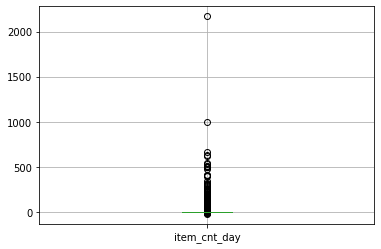

In [28]:
vendas_df[['item_cnt_day']].boxplot();

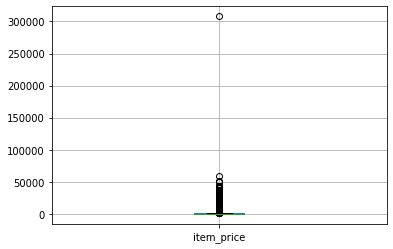

In [29]:
vendas_df[['item_price']].boxplot();

In [30]:
print('Preço maior que 10000')
print(vendas_df[(vendas_df.item_price > 100000) ])
print('Preço menor que 0')
print(vendas_df[(vendas_df.item_price < 0) ])
print('Quantidade maior que 1001')
print(vendas_df[vendas_df.item_cnt_day > 1001])

Preço maior que 10000
              date  date_block_num  shop_id  ...   ano  mes  dia
1163158 2013-12-13              11       12  ...  2013   12   13

[1 rows x 9 columns]
Preço menor que 0
             date  date_block_num  shop_id  ...   ano  mes  dia
484683 2013-05-15               4       32  ...  2013    5   15

[1 rows x 9 columns]
Quantidade maior que 1001
              date  date_block_num  shop_id  ...   ano  mes  dia
2909818 2015-10-28              33       12  ...  2015   10   28

[1 rows x 9 columns]


In [31]:
#mean = vendas_df[(vendas_df["shop_id"] == 32) & (vendas_df["item_id"] == 2973) & (vendas_df["date_block_num"] == 4) & (vendas_df["item_price"] > 0)]["item_price"].mean()
#vendas_treino_df.loc[vendas_df.item_price < 0, 'item_price'] = mean
vendas_df = vendas_df[(vendas_df.item_cnt_day < 1001) & (vendas_df.item_cnt_day > 0)]
vendas_df = vendas_df = vendas_df[(vendas_df.item_price < 100000) & (vendas_df.item_price > 0)]

### 3.4.6 Total de Vendas

In [32]:
vendas_df['total_vendas'] = vendas_df['item_price'] * vendas_df['item_cnt_day']
vendas_df.head(3)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,ano,mes,dia,total_vendas
0,2013-01-02,0,59,22154,999.00,1.0,2013,1,2,999.00
1,2013-01-03,0,25,2552,899.00,1.0,2013,1,3,899.00
3,2013-01-06,0,25,2554,1709.05,1.0,2013,1,6,1709.05


## **3.5 Juntando os Dados(Merge)**

In [33]:
tabelao_df = pd.merge(itens_df, categorias_df, on='item_category_id', how='inner')
tabelao_df = pd.merge(vendas_df,tabelao_df, on='item_id', how='inner')
tabelao_df = pd.merge(tabelao_df, lojas_df, on='shop_id', how='inner')

tabelao_df = tabelao_df.drop(columns=['shop_name','item_category_name','item_name','item_name_pt'])

#tabelao_df.set_index('date')
tabelao_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2928304 entries, 0 to 2928303
Data columns (total 13 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   date                   datetime64[ns]
 1   date_block_num         int64         
 2   shop_id                int64         
 3   item_id                int64         
 4   item_price             float64       
 5   item_cnt_day           float64       
 6   ano                    int64         
 7   mes                    int64         
 8   dia                    int64         
 9   total_vendas           float64       
 10  item_category_id       int64         
 11  item_category_name_pt  object        
 12  shop_name_pt           object        
dtypes: datetime64[ns](1), float64(3), int64(7), object(2)
memory usage: 312.8+ MB


In [34]:
tabelao_df.isnull().sum()

date                     0
date_block_num           0
shop_id                  0
item_id                  0
item_price               0
item_cnt_day             0
ano                      0
mes                      0
dia                      0
total_vendas             0
item_category_id         0
item_category_name_pt    0
shop_name_pt             0
dtype: int64

In [35]:
tabelao_df.item_category_name_pt = tabelao_df.item_category_name_pt.astype('category')
tabelao_df.date_block_num        = tabelao_df.date_block_num.astype('int32')
tabelao_df.shop_id               = tabelao_df.shop_id.astype('int32')
tabelao_df.item_id               = tabelao_df.item_id.astype('int32')
tabelao_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2928304 entries, 0 to 2928303
Data columns (total 13 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   date                   datetime64[ns]
 1   date_block_num         int32         
 2   shop_id                int32         
 3   item_id                int32         
 4   item_price             float64       
 5   item_cnt_day           float64       
 6   ano                    int64         
 7   mes                    int64         
 8   dia                    int64         
 9   total_vendas           float64       
 10  item_category_id       int64         
 11  item_category_name_pt  category      
 12  shop_name_pt           object        
dtypes: category(1), datetime64[ns](1), float64(3), int32(3), int64(4), object(1)
memory usage: 259.7+ MB


## 3.6 Dividindo os dados em base de treinamento e de teste

In [36]:
treino_df = tabelao_df[(tabelao_df.date <= '31/12/2014')]
teste_df  = tabelao_df[(tabelao_df.date >= '01/01/2015')]
treino_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2317533 entries, 0 to 2925111
Data columns (total 13 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   date                   datetime64[ns]
 1   date_block_num         int32         
 2   shop_id                int32         
 3   item_id                int32         
 4   item_price             float64       
 5   item_cnt_day           float64       
 6   ano                    int64         
 7   mes                    int64         
 8   dia                    int64         
 9   total_vendas           float64       
 10  item_category_id       int64         
 11  item_category_name_pt  category      
 12  shop_name_pt           object        
dtypes: category(1), datetime64[ns](1), float64(3), int32(3), int64(4), object(1)
memory usage: 205.5+ MB


# **4. Análise e Exploração dos Dados**

Não analisaremos por itens pois vemos que os itens costumam ter uma vida útil e nossa estratégia é analisar o total de vendas de uma forma mais macro. 

In [37]:
treino_df.pivot_table(index = ['item_id'],values = ['item_cnt_day'],columns = ['date_block_num'],fill_value = 0,aggfunc='sum')

item_cnt_day                    ...                            
date_block_num           0  1  2  3  4  5  6   ...  17  18  19  20  21  22  23
item_id                                        ...                            
0                         0  0  0  0  0  0  0  ...   0   0   0   1   0   0   0
1                         0  0  0  0  0  0  0  ...   0   1   1   1   1   0   0
2                         0  0  0  0  0  0  0  ...   0   0   1   0   0   1   0
3                         0  0  0  0  0  0  0  ...   0   1   1   0   0   0   0
4                         0  0  0  0  0  0  0  ...   0   0   0   1   0   0   0
...                     ... .. .. .. .. .. ..  ...  ..  ..  ..  ..  ..  ..  ..
22165                     0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0
22166                     0  0  0  0  0  0  0  ...  15  12  13  13  12  16  11
22167                     0  0  0  0  0  0  0  ...  56  47  47  39  49  49  40
22168                     2  2  1  0  0  0  0  ...   0   0   0   0   0   0   0
22169                     0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0

[19043 rows x 24 columns]

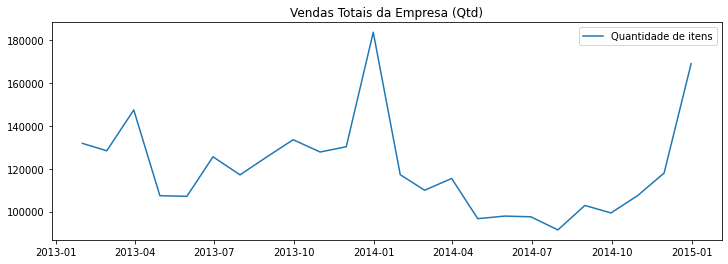

In [38]:
plt.figure(figsize = (12, 4))
plt.plot(treino_df[["date", "item_cnt_day"]].set_index("date").resample("M").sum(), label = "Quantidade de itens")
plt.title("Vendas Totais da Empresa (Qtd)")
plt.legend();

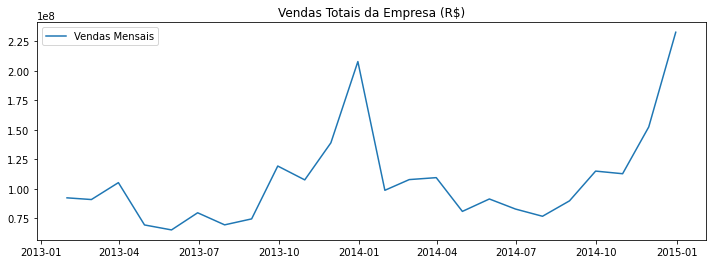

In [39]:
plt.figure(figsize = (12, 4))
plt.plot(treino_df[["date", "total_vendas"]].set_index("date").resample("M").sum(), label = "Vendas Mensais")
plt.title("Vendas Totais da Empresa (R$)")
plt.legend();

Componetes (tendência, sazonalidade e resíduo)

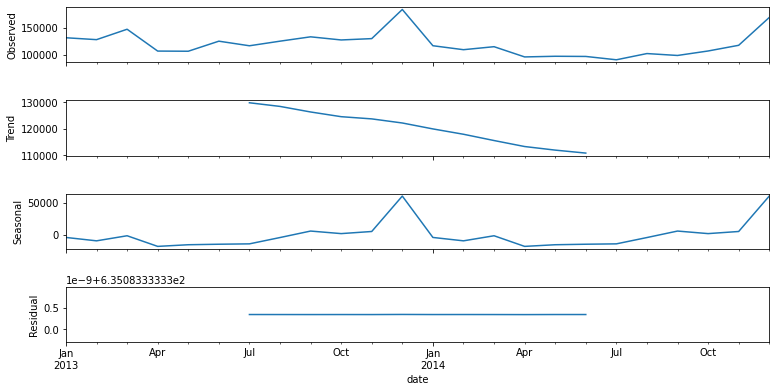

In [40]:
season = seasonal_decompose(treino_df[["date", "item_cnt_day"]].set_index("date").resample("M").sum(), freq=12)
fig = season.plot();
fig.set_size_inches(12,6)

As séries temporais podem ser decompostas em 3 componente: tendência, sazonalidade e resíduo.

Clara tendência de queda e sazonalidade forte em dezembro.

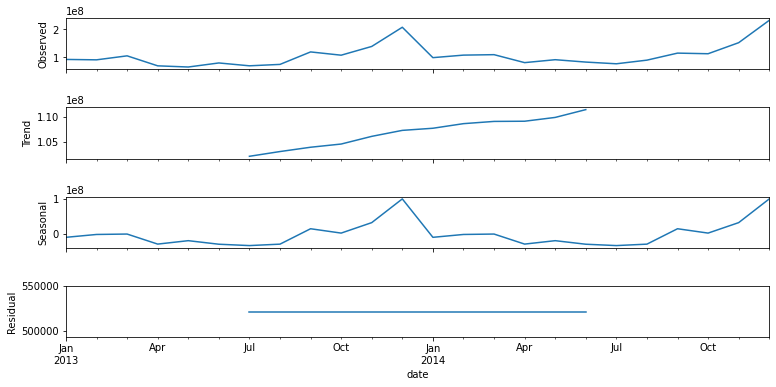

In [41]:
season = seasonal_decompose(treino_df[["date", "total_vendas"]].set_index("date").resample("M").sum(), freq=12)
fig = season.plot();
fig.set_size_inches(12,6)

Clara tendência de alta e sazonalidade forte em dezembro.

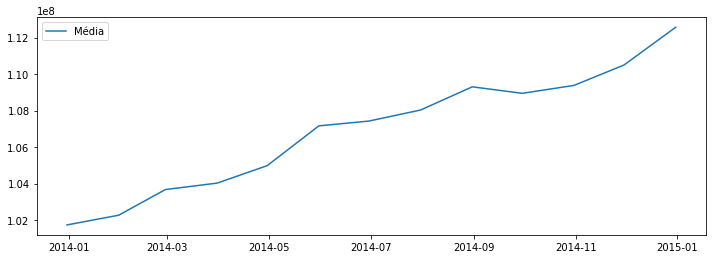

In [42]:
plt.figure(figsize=(12,4))
plt.plot(treino_df[["date", "total_vendas"]].set_index("date").resample("M").sum().rolling(window=12,center=False).mean(),label='Média')
plt.legend()

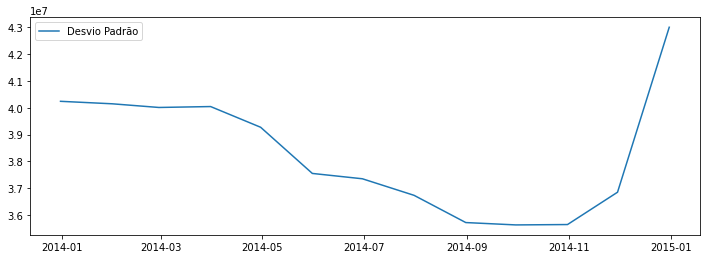

In [43]:
plt.figure(figsize=(12,4))
plt.plot(treino_df[["date", "total_vendas"]].set_index("date").resample("M").sum().rolling(window=12,center=False).std(),label='Desvio Padrão')
plt.legend()

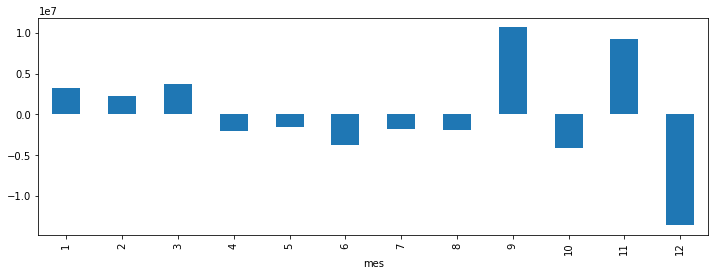

In [44]:
treino_df.total_vendas.diff(1).groupby(treino_df.mes).sum().plot(kind='bar', figsize=(12, 4))

# **5. Criação de Modelos de Machine Learning**

In [45]:
# Criando as séries agrupadas por total de vendas
#treino_agrupado_df = tabelao_df[(tabelao_df.date <= '31/12/2014')].groupby(['date'])['total_vendas'].sum()
#teste_agrupado_df  = tabelao_df[(tabelao_df.date >= '01/01/2015')].groupby(['date'])['total_vendas'].sum()

## **5.1 Prophet**

Biblioteca do facebook gratuito para previsão de séries temporais. Trabalha bem com tendencia, sazonalidade, feriados, erros. Rápida aplicação, fácil parametrização.

In [46]:
# Preparando os dados para rodar no prophet
prophet_treino_df         = treino_df.groupby(["date_block_num"])["total_vendas"].sum()
prophet_treino_df.index   = pd.date_range(start = '2013-01-01',end='2014-12-31', freq = 'MS')
prophet_treino_df         = prophet_treino_df.reset_index()
prophet_treino_df.columns = ['ds','y']

prophet_teste_df          = teste_df.groupby(["date_block_num"])["total_vendas"].sum()
prophet_teste_df.index   = pd.date_range(start = '2015-01-01',end='2015-10-31', freq = 'MS')
prophet_teste_df         = prophet_teste_df.reset_index()
prophet_teste_df.columns = ['ds','y']

In [47]:
m            = Prophet(yearly_seasonality=True) # Criando o modelo
m.fit(prophet_treino_df)                        # realizando o treinamento
forecast  = m.predict(prophet_teste_df)         # previsão do modelo

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.


In [48]:
forecast.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'yearly', 'yearly_lower', 'yearly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'],
      dtype='object')

In [49]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
5,2015-06-01,8.280696e+07,6.851384e+07,9.553524e+07
6,2015-07-01,8.277074e+07,6.476230e+07,9.931578e+07
7,2015-08-01,1.022539e+08,7.953834e+07,1.223817e+08
8,2015-09-01,1.070537e+08,7.868848e+07,1.309946e+08
9,2015-10-01,1.152552e+08,8.211039e+07,1.433719e+08


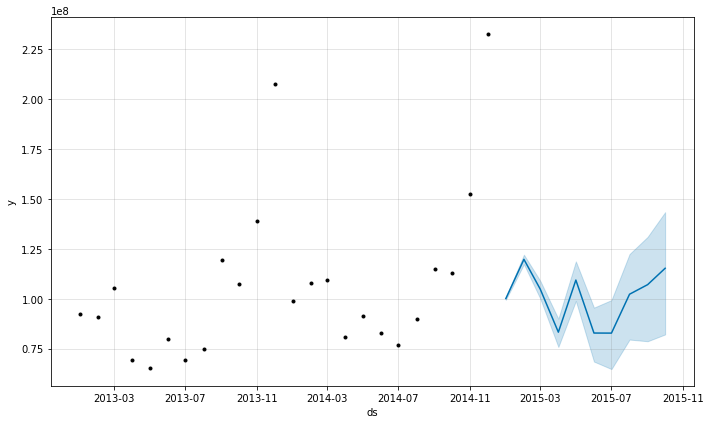

In [50]:
fig1 = m.plot(forecast)

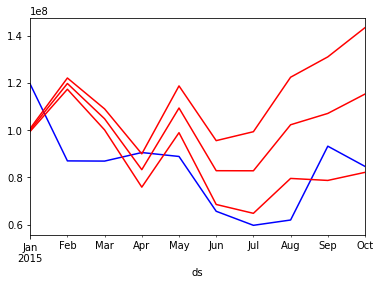

In [51]:
prophet_teste_df.set_index('ds')['y'].plot(color='blue')
forecast.set_index('ds')['yhat_lower'].plot(color='red')
forecast.set_index('ds')['yhat'].plot(color='red')
forecast.set_index('ds')['yhat_upper'].plot(color='red')

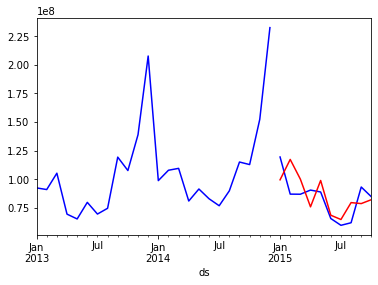

In [52]:
prophet_treino_df.set_index('ds')['y'].plot(color='blue')
prophet_teste_df.set_index('ds')['y'].plot(color='blue')
forecast.set_index('ds')['yhat_lower'].plot(color='red')

In [53]:
import itertools
import numpy as np
import pandas as pd

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet('flat').fit(prophet_treino_df)  # Fit model with given params
    df_cv = cross_validation(m, initial='0 days', period='304 days', horizon = '304 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['mse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2013-04-02 00:00:00 and 2014-01-31 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f08934f91d0>
INFO:fbprophet:n_changepoints greater than number of observations. Using 2.
INFO:fbprophet:n_changepoints greater than number of observations. Using 9.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonal

    changepoint_prior_scale  seasonality_prior_scale          rmse
0                     0.001                     0.01  2.044762e+15
1                     0.001                     0.10  2.044762e+15
2                     0.001                     1.00  2.044762e+15
3                     0.001                    10.00  2.044762e+15
4                     0.010                     0.01  2.044762e+15
5                     0.010                     0.10  2.044762e+15
6                     0.010                     1.00  2.044762e+15
7                     0.010                    10.00  2.044762e+15
8                     0.100                     0.01  2.044762e+15
9                     0.100                     0.10  2.044762e+15
10                    0.100                     1.00  2.044762e+15
11                    0.100                    10.00  2.044762e+15
12                    0.500                     0.01  2.044762e+15
13                    0.500                     0.10  2.044762

In [54]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01}


**Previsão diárizada**

In [55]:
# Preparando os dados para rodar no prophet
prophet_treino_df2         = treino_df.groupby(["date"])["total_vendas"].sum()
prophet_teste_df2          = teste_df.groupby(["date"])["total_vendas"].sum()
prophet_treino_df2.index   = pd.date_range(start = '2013-01-01',end='2014-12-31')
prophet_treino_df2         = prophet_treino_df2.reset_index()
prophet_treino_df2.columns = ['ds','y']
prophet_teste_df2.index   = pd.date_range(start = '2015-01-01',end='2015-10-31')
prophet_teste_df2         = prophet_teste_df2.reset_index()
prophet_teste_df2.columns = ['ds','y']

In [56]:
#m = Prophet(changepoint_prior_scale=0.08)# instanciando o modelo
m2            = Prophet(yearly_seasonality=True)
m2.fit(prophet_treino_df2) # realizando o treinamento
#futuro            = modelo.make_future_dataframe(periods = 12, freq = 'MS', include_history=True) # método auxiliar para previsão
forecast2  = m2.predict(prophet_teste_df2) # previsão do modelo
forecast2.tail(3)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
301,2015-10-29,5.217934e+06,1.557823e+06,6.067606e+06,5.091528e+06,5.362636e+06,-1.390023e+06,-1.390023e+06,-1.390023e+06,-3.586544e+05,-3.586544e+05,-3.586544e+05,-1.031369e+06,-1.031369e+06,-1.031369e+06,0.0,0.0,0.0,3.827911e+06
302,2015-10-30,5.221129e+06,2.486336e+06,7.021518e+06,5.094254e+06,5.366061e+06,-4.083247e+05,-4.083247e+05,-4.083247e+05,5.590281e+05,5.590281e+05,5.590281e+05,-9.673528e+05,-9.673528e+05,-9.673528e+05,0.0,0.0,0.0,4.812805e+06
303,2015-10-31,5.224325e+06,3.060623e+06,7.997320e+06,5.096980e+06,5.369780e+06,3.370233e+05,3.370233e+05,3.370233e+05,1.220605e+06,1.220605e+06,1.220605e+06,-8.835822e+05,-8.835822e+05,-8.835822e+05,0.0,0.0,0.0,5.561348e+06


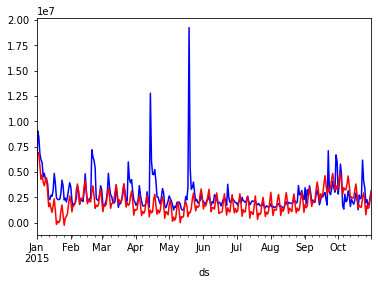

In [57]:
#prophet_treino_df2.set_index('ds')['y'].plot(color='blue')
prophet_teste_df2.set_index('ds')['y'].plot(color='blue')
forecast2.set_index('ds')['yhat_lower'].plot(color='red')
#forecast2.set_index('ds')['yhat'].plot(color='red')
#forecast2.set_index('ds')['yhat_upper'].plot(color='red')

# **6. Apresentação dos Resultados**

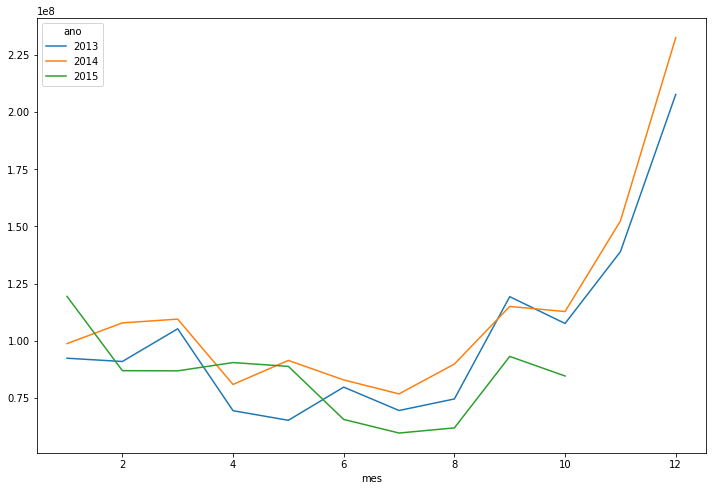

In [58]:
data = tabelao_df.groupby(
    ['ano','mes']).agg({'total_vendas': np.sum}).reset_index().pivot(
    index='mes', columns='ano', values='total_vendas')
data.plot(figsize=(12, 8))

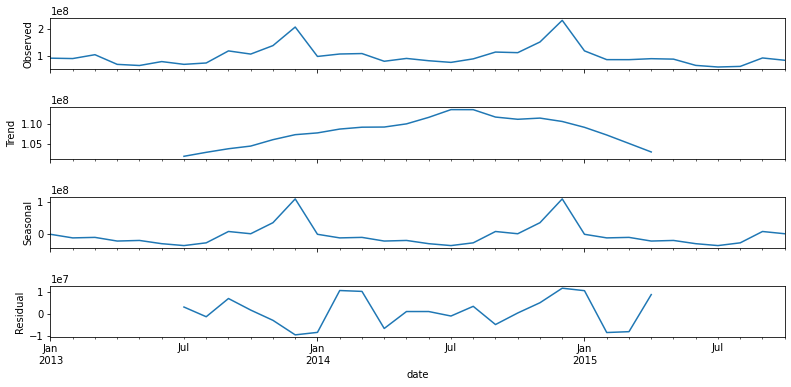

In [59]:
season = seasonal_decompose(tabelao_df[["date", "total_vendas"]].set_index("date").resample("M").sum(), freq=12)
fig = season.plot();
fig.set_size_inches(12,6)

In [60]:
 tabelao_df[(tabelao_df.date > '01/01/2015') & (tabelao_df.date > '31/01/2014')& (tabelao_df.total_vendas > 1000000)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,ano,mes,dia,total_vendas,item_category_id,item_category_name_pt,shop_name_pt
2452606,2015-04-14,27,12,3731,1904.548077,624.0,2015,4,14,1.188438e+06,30,Jogos para PC - edições padrão,Loja online de situações de emergência
2453095,2015-09-30,32,12,9248,1692.526158,669.0,2015,9,30,1.132300e+06,80,Serviço - Ingressos,Loja online de situações de emergência
2453302,2015-05-19,28,12,10212,8499.000000,140.0,2015,5,19,1.189860e+06,29,Jogos para PC - Edições de colecionador,Loja online de situações de emergência
2926722,2015-09-30,32,55,9249,1702.825746,637.0,2015,9,30,1.084700e+06,8,Ingressos (número),Armazém digital 1C-Online


In [61]:
lojas_sem_vendas_2015 = tabelao_df.groupby(["date_block_num",'shop_id'])["item_cnt_day"].sum()
lojas_sem_vendas_2015=lojas_sem_vendas_2015.unstack(level=1)
lojas_sem_vendas_2015=lojas_sem_vendas_2015.fillna(0)
lojas_sem_vendas_2015=(lojas_sem_vendas_2015[24:]==0).all()
lojas_sem_vendas_2015=np.array(lojas_sem_vendas_2015.index[lojas_sem_vendas_2015==True])
list(lojas_sem_vendas_2015)

[8, 13, 23, 32]

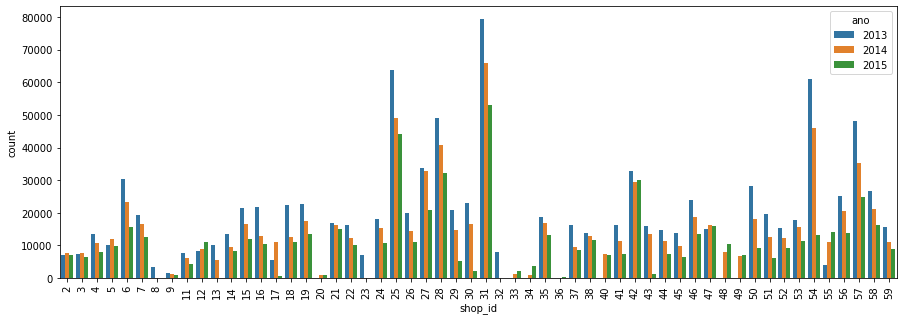

In [62]:
fig, ax = plt.subplots(figsize=(15,5))
sns.countplot(x='shop_id', hue='ano'
              ,data =  tabelao_df[(tabelao_df.mes <= 10)], ax=ax)
plt.xticks(rotation=90);

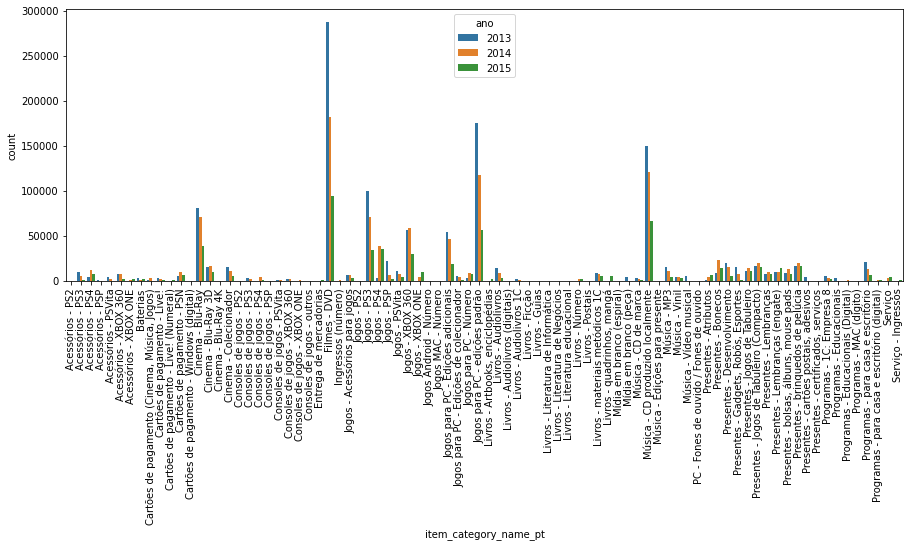

In [63]:
fig, ax = plt.subplots(figsize=(15,5))
sns.countplot(x='item_category_name_pt', hue='ano'
              ,data = tabelao_df, ax=ax)
plt.xticks(rotation=90);